<AxesSubplot:xlabel='Date'>

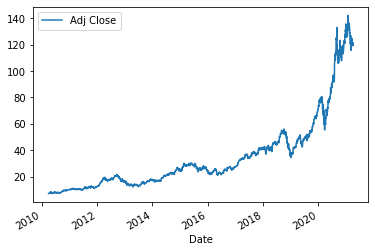

In [2]:
import pandas_datareader as pdr
from datetime import datetime
AAPL = pdr.DataReader('AAPL', data_source='yahoo', 
                       start=datetime(2010, 4, 1), end=datetime(2021, 3, 31))
AAPL.plot(y='Adj Close')

<AxesSubplot:xlabel='Date'>

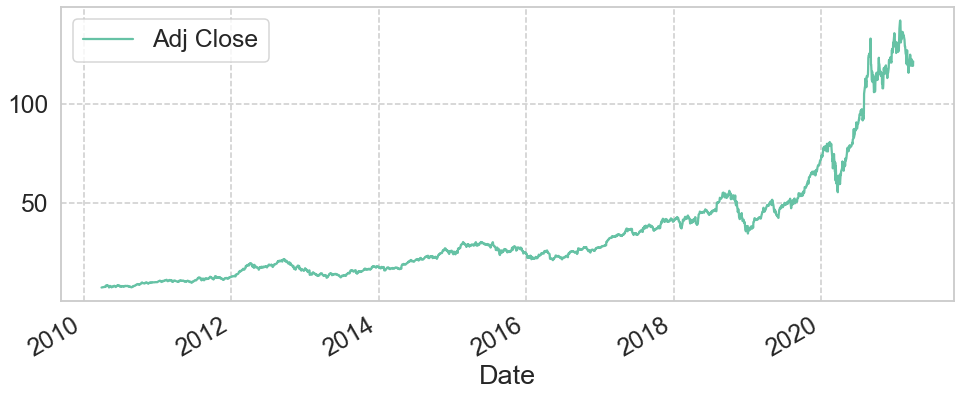

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(context='talk', style='whitegrid', palette='Set2',
                font_scale=1.5, 
                rc={'figure.figsize': (16, 6), 
                    'grid.linestyle': '--'}) # ここらへんのoptionは各人の好みで
AAPL.plot(y='Adj Close')

<AxesSubplot:title={'center':'GS'}, xlabel='Date'>

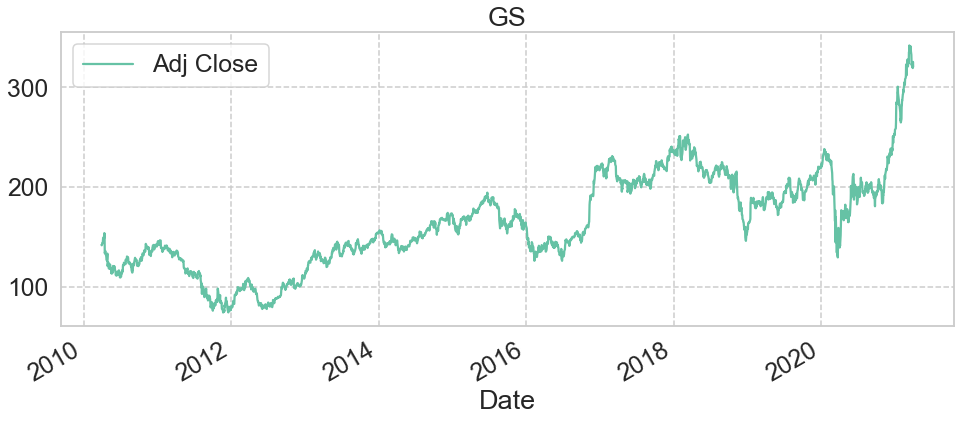

In [4]:
GS = pdr.DataReader('GS', 
                        data_source='yahoo',
                        start=datetime(2010, 4,1),
                        end=datetime(2021, 3, 31))
GS.plot(y='Adj Close', title='GS')

<AxesSubplot:title={'center':'USDJPY'}, xlabel='Date'>

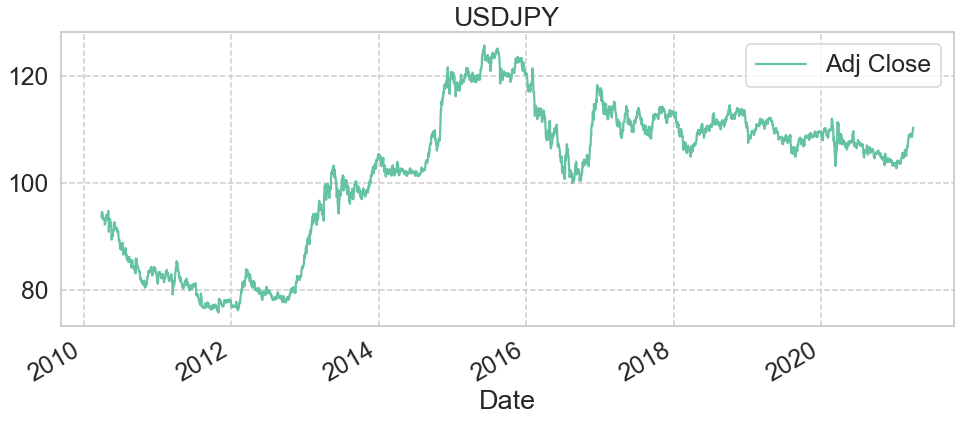

In [5]:
USDJPY = pdr.DataReader('USDJPY=X', data_source='yahoo', start=datetime(2010, 4, 1), end=datetime(2021, 3, 31))
USDJPY.plot(y='Adj Close', title='USDJPY')

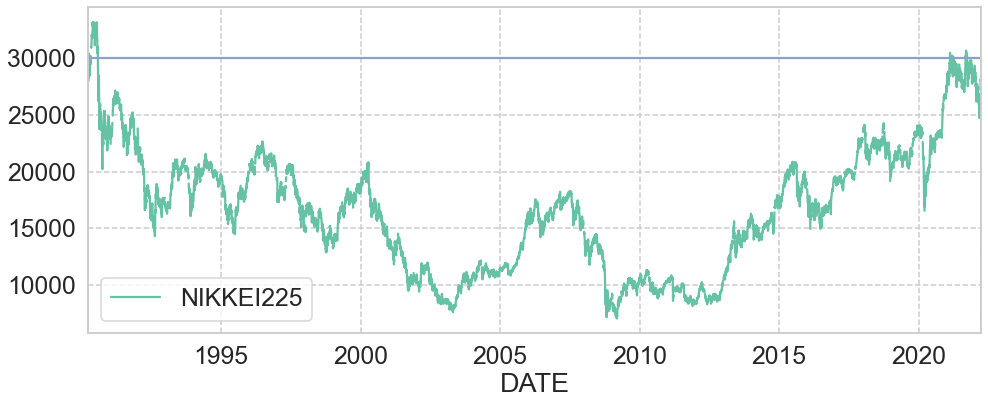

In [6]:
NIKKEI225 = pdr.DataReader('NIKKEI225', data_source='fred', start=datetime(1990, 4, 1), end=datetime(2022,3,31))
ax = NIKKEI225.plot()
ax.axhline(30000, color='C2')

In [10]:
def SMA_trade(data, sym, SMA_S, SMA_L):
    df = (
        data['Adj Close'].to_frame().copy().rename(columns={'Adj Close': sym})
    )
    df['SMA_S'] = df[sym].rolling(SMA_S).mean()
    df['SMA_L'] = df[sym].rolling(SMA_L).mean()
    df.dropna(inplace=True)
    df['position'] = np.where(df['SMA_S'] > df['SMA_L'], +1, -1)
    df['returns'] = np.log(df[sym]/df[sym].shift(1))
    df['strategy'] = df['position'].shift(1) * df['returns']
    
    return df

<AxesSubplot:xlabel='Date'>

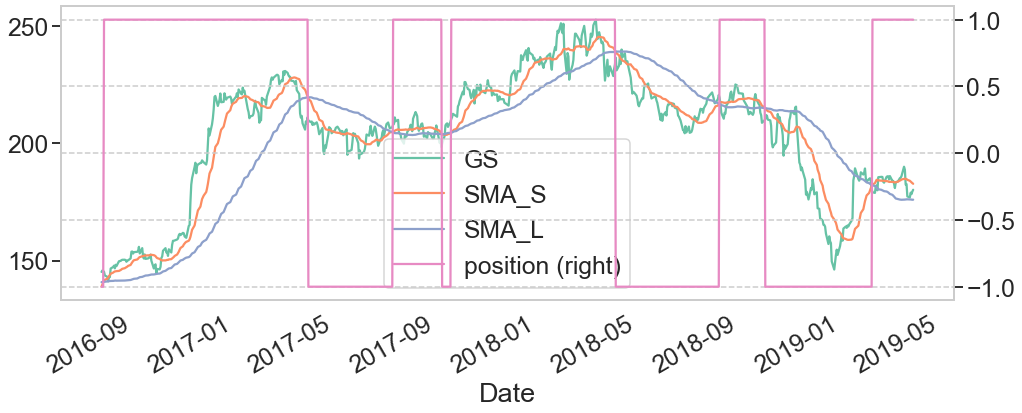

In [11]:
sym = 'GS'
start, end = '2016-04-01', '2019-03-31'
sma_s, sma_l = 20, 80
df = SMA_trade(data=eval(sym)[start:end], sym=sym, SMA_S=sma_s, SMA_L=sma_l)
df[[sym, 'SMA_S', 'SMA_L', 'position']].plot(secondary_y=['position'])

<AxesSubplot:title={'center':'GS'}, xlabel='Date'>

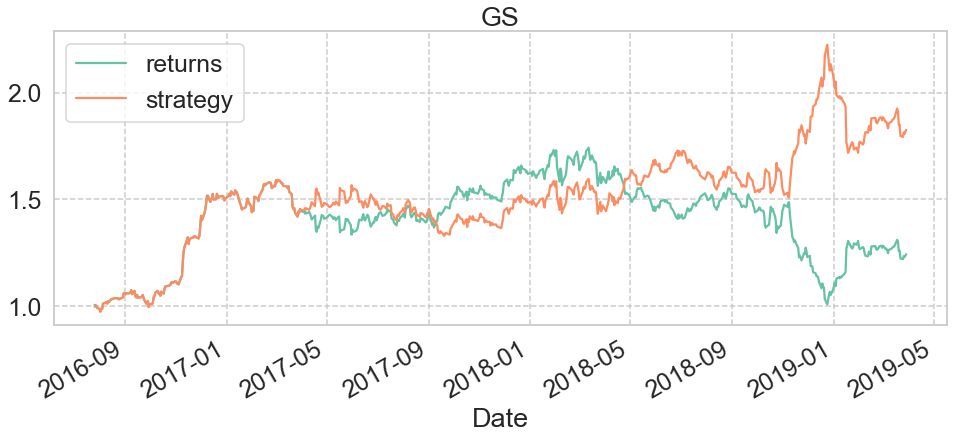

In [12]:
df[['returns','strategy']].cumsum().apply(np.exp).plot(title='GS')

In [13]:
np.exp(df[['returns','strategy']].sum())

returns     1.241492
strategy    1.825304
dtype: float64

In [15]:
sym = 'GS'
start, end = '2016-04-01', '2019-03-31'
GS_test = eval(sym)[start:end]
results = []
for sma_s in np.arange(5, 26, 5):
    for sma_l in np.arange(50, 121, 10):
        df = SMA_trade(data=GS_test, sym=sym, SMA_S=sma_s, SMA_L=sma_l)
        perf = np.exp(df[['returns','strategy']].sum())
        results.append({'sma_s': sma_s,
                        'sma_l': sma_l,
                        'market': perf['returns'],
                        'strategy': perf['strategy'],
                        'out': perf['strategy'] - perf['returns']
                        })
results = pd.DataFrame(results)
results.sort_values('out', ascending=False).head(5)

,sma_s,sma_l,market,strategy,out
35,25,80,1.241492,2.186393,0.944901
36,25,90,1.223804,1.965481,0.741677
28,20,90,1.223804,1.855019,0.631216
23,15,120,1.192381,1.789752,0.597370
27,20,80,1.241492,1.825304,0.583812


<AxesSubplot:xlabel='sma_l', ylabel='sma_s'>

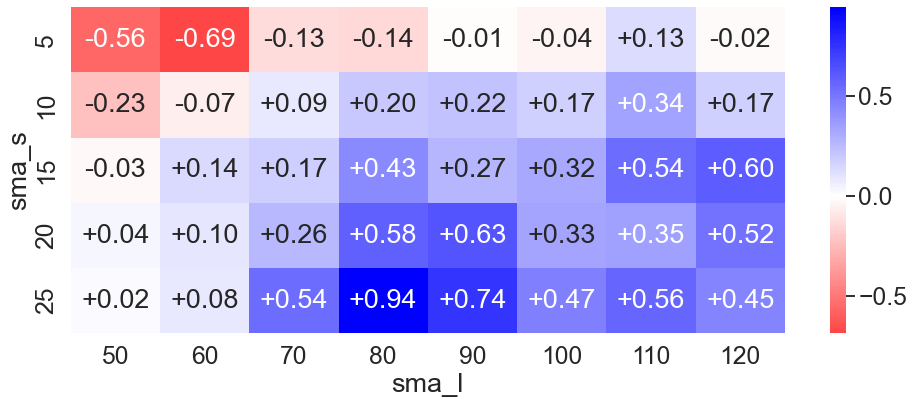

In [16]:
sns.heatmap(results.pivot(index='sma_s', columns='sma_l', values='out'),
            annot=True, fmt='+.2f', center=0, cmap='bwr_r')

In [17]:
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
    
class SmaCross(Strategy):
    n1 = 15
    n2 = 60
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()
    
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In [18]:
from backtesting import Backtest
    
start, end = '2016-04-01', '2019-03-31'
data = GS[start:end]
bt = Backtest(data, SmaCross, cash=10_000)
stats = bt.run()
bt.plot()

Row(id='1449', ...)

In [19]:
stats = bt.optimize(n1=range(5, 26, 5), n2=range(10, 121, 10),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
    
print(stats._strategy) # SmaCross(n1=25,n2=70)

SmaCross(n1=25,n2=70)
